# Week 6: Neural networks
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
This notebook contains exercises guiding you from PyTorch fundamentals to advanced neural‐network workflows using Skorch, transfer learning, and Hugging Face models. It expands and reinforces the topics seen during week 6.


---

## Part 1: Simple Networks in PyTorch (Exercises 1–3)

### Exercise 1: Forward Pass by Hand

**Goal:** Define a 2‑layer linear network and manually compute its forward pass. Note: It is useful to learn Pytorch or Tensorflow apart from Scikit-learn, for that reason, we will use pytorch in this tutorial.

**Explanation:** You will implement `forward()` and verify outputs match manual matrix multiplications.


In [1]:
import torch
import torch.nn as nn

class TwoLayerNet(nn.Module):
    def __init__(self, in_features, hidden, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden) # Try adding more layers
        self.fc2 = nn.Linear(hidden, out_features)

    def forward(self, x):
        # Linear → ReLU → Linear
        x1 = self.fc1(x)
        a1 = torch.tanh((x1))
        x2 = self.fc2(a1)
        return x2

# Sample input
d = torch.randn(1, 4)
model = TwoLayerNet(4, 5, 3)
out = model(d)
print("Output:", out)

Output: tensor([[0.3079, 0.2182, 0.2759]], grad_fn=<AddmmBackward0>)



### Exercise 2: Backward Pass and Gradients

**Goal:** Compute gradients by hand for a simple scalar loss, then verify with `autograd`.

**Explanation:** Illustrate derivative computation and gradient storage in `model.parameters()`.


In [2]:
# Use same TwoLayerNet from Exercise 1
criterion = nn.MSELoss()
target = torch.randn(1, 3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Forward
output = model(d)
loss = criterion(output, target)

# Backward
debug_before = {name: p.grad for name, p in model.named_parameters()}
loss.backward()

debug_after = {name: p.grad.clone() for name, p in model.named_parameters()}
print("Gradients:", debug_after)

Gradients: {'fc1.weight': tensor([[-0.0014, -0.0186, -0.0218, -0.0198],
        [-0.0330, -0.4404, -0.5176, -0.4706],
        [ 0.0055,  0.0731,  0.0859,  0.0781],
        [-0.0102, -0.1359, -0.1597, -0.1452],
        [-0.0056, -0.0748, -0.0878, -0.0799]]), 'fc1.bias': tensor([-0.0204, -0.4850,  0.0804, -0.1497, -0.0823]), 'fc2.weight': tensor([[ 0.3417,  0.0412,  0.2853,  0.2978,  0.2090],
        [ 0.8370,  0.1010,  0.6988,  0.7293,  0.5119],
        [-0.1360, -0.0164, -0.1136, -0.1185, -0.0832]]), 'fc2.bias': tensor([-0.4151, -1.0166,  0.1652])}



### Exercise 3: Custom Training Loop

**Goal:** Write a full training loop: forward, loss, backward, optimizer step. Even though we will use Skorch for the rest of the exercises (to keep a scikit-learn-like sintax), it is useful to do it manually once.

**Explanation:** Emphasize zeroing grads, stepping optimizer, tracking loss.


In [3]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train() # Investigate why this
    optimizer.zero_grad()
    out = model(d)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    # Add a validation loop
    model.eval() # why?
    print(f"Epoch {epoch}: loss={loss.item():.4f}")

# Add a test loop
model.eval()

Epoch 0: loss=0.9247
Epoch 1: loss=0.5202
Epoch 2: loss=0.2973
Epoch 3: loss=0.1698
Epoch 4: loss=0.0963
Epoch 5: loss=0.0542
Epoch 6: loss=0.0303
Epoch 7: loss=0.0168
Epoch 8: loss=0.0093
Epoch 9: loss=0.0051


TwoLayerNet(
  (fc1): Linear(in_features=4, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
)

**Tasks:**
1. Add validation and test loops. Validation happens after each iteration of training. Test happens afterwards.
2. Use a similar neural network to classify the iris dataset from week 2



---

## Part 2: Skorch for High‑Level Training (Exercises 4–7)

### Exercise 4: Wrapping a PyTorch Module with Skorch

**Goal:** Create a `NeuralNetClassifier` for the TwoLayerNet.

**Explanation:** Show how Skorch simplifies fit/predict. We use Skorch to keep the sintax similar to Scikit-learn. It takes care of the training loop!


In [ ]:
# First we need to install skorch
#!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [skorch]


In [5]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    TwoLayerNet,
    module__in_features=4, # Model parameters
    module__hidden=10,
    module__out_features=2,
    max_epochs=5,
    lr=0.1,
    iterator_train__shuffle=True,
    criterion=nn.CrossEntropyLoss
)
# Fit on dummy data
X = torch.randn(100, 4).numpy()
y = (torch.randint(0, 2, (100,))).numpy()
net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8010       0.3500        0.7736  0.0022
      2        0.7809       0.3500        0.7572  0.0012
      3        0.7641       0.3500        0.7432  0.0010
      4        0.7502       0.3500        0.7314  0.0009
      5        0.7386       0.4500        0.7213  0.0010


,module,<class '__main__.TwoLayerNet'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x15bb4c260>
,classes,None
,optimizer,<class 'torch.optim.sgd.SGD'>
,lr,0.1
,max_epochs,5
,batch_size,128
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>



### Exercise 5: Training on Synthetic “Moons” Dataset

**Goal:** Load `sklearn.datasets.make_moons`, train Skorch classifier, plot.

**Explanation:** Visualize decision boundary on 2D toy data. You will try two approaches. The first one with architecture A should have two output layers and use the criterion `torch.nn.CrossEntropyLoss` in the `NeuralNetClassifier`. The second one will have only one output neuron and use the `NeuralNetBinaryClassifier`. This classifier uses by default the `torch.nn.BCEWithLogitsLoss` which means that you need to return the *logits* (avoiding a nonlinearity in the output layer).




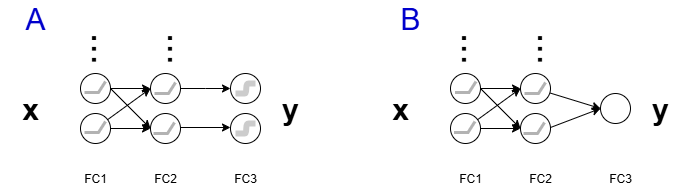



In [6]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from skorch import NeuralNetBinaryClassifier

# A
class MoonsNetCrossEntropy(nn.Module):
    # Your code here


#B
class MoonsNetBCE(nn.Module):
    # Your code here



X, y = make_moons(500, noise=0.2)

net = NeuralNetBinaryClassifier(
    MoonsNetBCE, # change the network here
    max_epochs=1000,
    lr=0.01,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam # Experiment with different optimizers
    )

net.fit(X.astype('float32'), y.astype('float32'))
# Function to plot boundary omitted
plot_decision_boundary(net, X, y)

IndentationError: expected an indented block after class definition on line 6 (1076571115.py, line 11)

**Tasks:**
1. Try both architectures. Modify learning rate, number of neurons in the hidden layers and optimizer. You should reach > 90% validation accuracy.
2. You will implement the decision boundary in the next exercises, but you can also use external libraries like: [mlxtend](https://rasbt.github.io/mlxtend/)


### Exercise 6: Decision Boundary Visualization

**Goal:** Implement `plot_decision_boundary(net, X, y)`.

**Explanation:** Meshgrid over feature space, predict on grid.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(net, X, y, cmap='viridis'):
    # create mesh, predict, contourf, scatter data
    xx, yy = np.meshgrid(np.linspace(-2,3,200), np.linspace(-1.5,2,200)) # Investigate the purpose of this function

    Z = net.predict(np.c_[xx.ravel(), yy.ravel()].astype('float32')).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3) # What does this do? Change the parameters
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title('MLP Decision Boundary')
    plt.show()
    pass


### Exercise 7: MNIST Classification

**Goal:** Use `skorch.dataset.FashionMNIST` or load MNIST, train a simple MLP via Skorch.

**Explanation:** When creating your MLP, you need to decide how many neurons you need at the input, how many at the output and how many layers. You also need to try different criterions.


In [ ]:
from skorch.dataset import Dataset
from torchvision import transforms, datasets


class SimpleMLP(nn.Module):
  # Your code here

data = datasets.MNIST('.', download=True, transform=transforms.ToTensor())

net = NeuralNetClassifier(
    SimpleMLP,  # define a small CNN module
    max_epochs=10, # More epochs
    lr=0.01,
    iterator_train__batch_size=64,
)
net.fit(data.data.numpy(), data.targets.numpy())


---

## Part 3: Learning Strategies (Exercises 8–10)

### Exercise 8: Learning Rate Scheduler

**Goal:** Integrate `StepLR` into Skorch via `lr_scheduler` parameter.

**Explanation:** Show decay of LR and its effect on training on the previous network.

A learning‐rate scheduler in PyTorch (and Skorch) automatically adjusts the optimizer’s learning rate during training according to a predefined rule. Instead of keeping a fixed rate, you can—for example—decay the LR every few epochs or when your validation loss plateaus, which often yields faster convergence and better final accuracy.

Common strategies:

- Step decay (StepLR): multiply LR by γ every k epochs

- Exponential decay (ExponentialLR): multiply LR by γ every epoch

- Plateau‐based (ReduceLROnPlateau): reduce LR when a monitored metric stops improving


In [ ]:
net.lr_scheduler = torch.optim.lr_scheduler.StepLR
net.lr_scheduler__step_size = 5
net.lr_scheduler__gamma = 0.5
net.fit(X, y)

**Task:** Generate a plot of the loss vs. epochs with and without the scheduler. Investigate the overfitting.


### Exercise 9: Custom Weight Initialization

**Goal**: Implement and compare different weight initialization schemes (Xavier, Kaiming, and normal) in a Skorch training run, and observe their effect on convergence.

**Explanation**: Proper initialization can speed up training and avoid vanishing/exploding gradients. Students will write an initialization function, plug it into their model, and train on a simple dataset (e.g., moons or MNIST) to compare learning curves.


In [ ]:
# 1) Define a small network
torch.manual_seed(0)
class InitNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# 2) Initialization functions
def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        nn.init.zeros_(m.bias)

# 3) Prepare data
X, y = make_moons(200, noise=0.2, random_state=0)

# 4) Train with different initializations
results = {}
for name, init_fn in [('xavier', init_xavier), ('kaiming', init_kaiming), ('normal', init_normal)]:
    net = NeuralNetClassifier(
        InitNet,
        max_epochs=30,
        lr=0.1,
        iterator_train__shuffle=True,
        train_split=None,
        verbose=0,
        criterion=nn.CrossEntropyLoss
    )
    # Apply init after the module is initialized by Skorch
    net.initialize()
    net.module_.apply(init_fn) # Apply the initialization

    history = net.fit(X.astype('float32'), y.astype('int64')).history
    results[name] = [epoch['train_loss'] for epoch in history] # Corrected access to training loss

epochs = range(1, 31)
print(results)
for name, losses in results.items():
    plt.plot(epochs, losses, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Loss Curves for Different Initializations')
plt.show()

**Task:** Try the different initialization schemes with the MNIST dataset network from the previous exercise


### Exercise 10: Early Stopping Callback

**Goal:** Use skorch.callbacks.EarlyStopping to halt training when validation performance stalls, preventing overfitting and saving compute time.

**Explanation:** Early stopping watches a chosen metric (e.g., validation loss or accuracy). If that metric doesn't improve by at least a specified threshold for patience epochs, training stops early. This avoids wasting epochs on diminishing returns and can improve generalization.


In [ ]:
from skorch.callbacks import EarlyStopping

# Try one of the previous networks

net.callbacks.append(
    EarlyStopping(patience=3)
)
net.fit(X, y)

**Task:** Plot the loss results with and without early stopping

### Exercise 10: Learning strategies - application

Apply all the techniques seen before to the solution of this classification problem: Two classes but aling the arms of a spiral. Here is a sample of how your final result should look like:

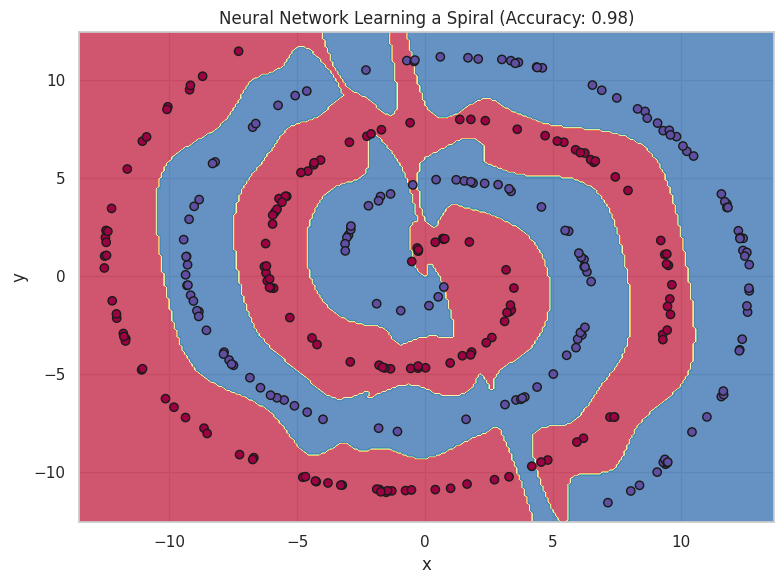

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Create a spiral dataset
def generate_spiral(n_points, noise=0.2):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    X1 = np.hstack((d1x, d1y))

    d2x = np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d2y = -np.sin(n) * n + np.random.rand(n_points, 1) * noise
    X2 = np.hstack((d2x, d2y))

    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(n_points), np.ones(n_points)))

    return X, y

# Generate data
X, y = generate_spiral(500)

# Your code here


---

## Part 4: Convolutional Neural Networks (Exercises 11–13)

### Exercise 12: Build a Simple CNN and Explore Convolution Transformations

**Goal:** Implement `SimpleCNN` with two conv layers, then investigate tensor shapes, channel dimensions, and pooling effects.

**Explanation:** Students will step through forward propagation manually to observe how spatial dimensions and channel counts change after each layer and pooling operation.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"After conv1 (16 channels, no pooling): {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        print(f"After pool1 (downsample by 2): {x.shape}")

        x = self.conv2(x)
        print(f"After conv2 (32 channels, no pooling): {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        print(f"After pool2 (downsample by 2): {x.shape}")

        x = x.view(x.size(0), -1)
        print(f"After flatten: {x.shape}")
        x = F.relu(self.fc1(x))
        print(f"After fc1: {x.shape}")
        return self.fc2(x)

# Sample run
dummy = torch.randn(1, 1, 28, 28)
model = SimpleCNN()
out = model(dummy)
print(f"Output logits shape: {out.shape}")


**Experiments:**

1. **Kernel size & padding:** Change `kernel_size` to 5, padding to 2; rerun and note shape changes.
2. **Stride variations:** Set `stride=2` in conv layers; observe spatial reduction without pooling.
3. **Pooling types:** Replace `MaxPool2d` with `AvgPool2d`; compare feature map statistics (mean, std).
4. **Channel analysis:** After `conv1`, compute per-channel activation norms (`x.norm(dim=(0,2,3))`) to see which filters activate more.

---

### Exercise 13: Visualize and Analyze Convolutional Kernels and Activations

**Goal:** Extract kernels from the first conv layer, visualize as images, and plot activation statistics channel‑wise.

**Explanation:** Understanding what features each filter learns and how activations behave helps interpret CNN internals.


In [ ]:
import matplotlib.pyplot as plt

# Extract weights and normalize to [0,1]
kernels = model.conv1.weight.data.clone()  # shape [16, 1, K, K]
min_w, max_w = kernels.min(), kernels.max()
kernels = (kernels - min_w) / (max_w - min_w)

# Plot the first 8 kernels
grid = kernels[:8, 0, :, :]  # take channel dimension
fig, axes = plt.subplots(2, 4, figsize=(8,4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(grid[i].cpu(), cmap='gray')
    ax.set_title(f"Kernel {i}")
    ax.axis('off')
plt.show()

# Activation statistics experiment
with torch.no_grad():
    x = torch.randn(10,1,28,28)
    act1 = model.conv1(x)
    act1 = F.relu(act1)
    # Compute channel means and stds
    means = act1.mean(dim=(0,2,3)).cpu()
    stds  = act1.std(dim=(0,2,3)).cpu()

# Plot channel mean vs std
plt.figure()
plt.scatter(means, stds)
plt.xlabel('Mean activation')
plt.ylabel('Std activation')
plt.title('Channel activation statistics after conv1')
plt.show()


**Experiments:**

1. **Before vs After Pooling:** Compare activation stats computed on `act1` vs after `F.max_pool2d(act1,2)`.
2. **Effect of Input Variance:** Pass inputs with different noise levels (`sigma` from 0.1 to 1.0) and plot how activation distributions shift.
3. **Filter response on real data:** Use samples from MNIST to visualize which kernels fire strongest on certain digits. : CNN on CIFAR-10 via Skorch

---

### Exercise 14: Applying a CNN

**Goal:** Train `SimpleCNN` or a deeper conv net on CIFAR-10.

**Explanation:** Use data augmentation via transforms.


In [ ]:
from torchvision import transforms, datasets

# Create a NeuralNetCLassifier wrapper for your netowork
# Your code here

transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.ToTensor()])
trainset = datasets.CIFAR10('.', train=True, transform=transform, download=True)
net.fit(trainset.data, trainset.targets)


---

## Part 5: ResNet and Transfer Learning (Exercises 14–17)

### Exercise 15: Load Pretrained ResNet

**Goal:** Load a pretrained ResNet18, inspect its architecture, count parameters, and visualize intermediate activations for a sample input tensor.

**Explanation:** Understanding model internals helps demystify deep architectures. Students will print the model summary, calculate total and trainable parameters, register forward hooks to capture activations from key layers, and observe activation output shapes.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# 1) Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)

# 2) Inspect architecture
print(resnet)  # model layers and blocks
# Count parameters
total_params = sum(p.numel() for p in resnet.parameters())
trainable   = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}, Trainable: {trainable:,}")

# 3) Register hooks for activations
activations = {}
def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

# Hook into conv1 and first conv of layer1 and layer2
resnet.conv1.register_forward_hook(hook_fn('conv1'))
resnet.layer1[0].conv1.register_forward_hook(hook_fn('layer1_block0'))
resnet.layer2[0].conv1.register_forward_hook(hook_fn('layer2_block0'))

# 4) Forward a dummy tensor to collect activations
dummy = torch.randn(1, 3, 224, 224)
resnet.eval()
with torch.no_grad():
    _ = resnet(dummy)

# 5) Print activation shapes
for name, act in activations.items():
    print(f"{name} output shape: {tuple(act.shape)}")


### Exercise 15: Finetune a ResNet

**Goal:** Adapt a pretrained ResNet18 to classify CIFAR-10 images, train the new head, then display test images with predicted and true labels.

**Explanation:** Transfer learning on small datasets speeds up convergence. Students will replace the final fully-connected layer, train on CIFAR-10’s 10 classes, and visualize predictions.



In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from skorch import NeuralNetClassifier

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Prepare CIFAR-10 data with resizing to 224×224
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
print(trainset.targets)
testset  = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

# 2) Define a Skorch-compatible module
class ResNetCIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained ResNet18 and modify head
        self.resnet = models.resnet18(pretrained=True)
        # Freeze all layers except the final FC layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Replace the final layer with one appropriate for the task
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

# 3) Wrap the module with Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    ResNetCIFAR10,
    max_epochs=1,  # Reduced epochs for demonstration
    lr=1e-3,
    # Use the DataLoader directly with Skorch
    batch_size=32,
    criterion=nn.CrossEntropyLoss,
    device=device, # Ensure the model is moved to the correct device
)

# 4) Train the model using the DataLoader
labels = torch.tensor(trainset.targets, dtype=torch.long).numpy()
net.fit(trainset, y = labels)

# 5) Evaluate and display predictions (using test_loader as before)
model = net.module_ # Get the PyTorch module from Skorch
model.eval()


pred = net.predict(testset)

# 6) Plot a batch of test images with labels
fig, axes = plt.subplots(2, 8, figsize=(16,4))
classes = trainset.classes

for idx, ax in enumerate(axes.flatten()):
    img = images[idx].permute(1,2,0).cpu().numpy()
    # Denormalize image if necessary (depends on the transforms used)
    # For simple ToTensor, no denormalization needed for display
    ax.imshow(img)
    ax.set_title(f"P: {classes[preds[idx]]} T: {classes[labels[idx]]}")
    ax.axis('off')
plt.show()


### Exercise 16: Fine‑Tune for Custom Dataset

**Goal:** (Advance) Replace `fc` head as before, train last layer(s) on new classes. Choose a dataset from the ones available to pytorch related to image classification.

**Explanation:** Freeze base layers, adjust learning rates.


In [ ]:
for param in model.parameters(): param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_new_classes)
# Skorch wrap and fit


### Exercise 17: Layer Freezing Strategies

**Goal:** Experiment with freezing different depths (none, half, full backbone).

**Explanation:** Compare performance and training speed.


In [ ]:
# Load dataset

# Create model

# Train with skorch wrapper or pytorch

# Evaluate


---

## Part 6: Autoencoders (Exercises 18–20)

### Exercise 18: Build a Simple Autoencoder

**Goal:** Investigate the autoencoder architecture. Create encoder and decoder, train on MNIST reconstruction.

**Explanation:** Minimize MSE between input and reconstruction.


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 64), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(64, 784), nn.Sigmoid())
    def forward(self, x):
        z = self.encoder(x.view(x.size(0), -1))
        out = self.decoder(z)
        return out.view(x.size())

# Load dataset

# Wrap around skorch

# Fit

# Evaluate


### Exercise 19: ResNet-based Autoencoder

**Goal:** (Advanced) Build an autoencoder whose encoder is a pretrained ResNet backbone and a custom decoder, then train it end‑to‑end with Skorch.

**Explanation:** We reuse ResNet as a feature extractor (encoder), then learn a decoder of transposed convolutions to reconstruct input images. Skorch’s `NeuralNetRegressor` handles training.


In [ ]:
!pip install skorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from skorch import NeuralNetRegressor

# Define ResNetAutoencoder
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Pretrained ResNet18 encoder, drop avgpool and fc
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]  # up to last conv layer
        self.encoder = nn.Sequential(*modules)
        # Decoder: Upsample back to 3x224x224
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1), # It is a bit more complicated with CNNs! Investigate this type of layer
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        z = self.encoder(x)        # [B, 512, 7, 7]
        recon = self.decoder(z)    # [B, 3, 224, 224]
        return recon

# Data preparation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10('.', download=True, transform=transform)

# Wrap in Skorch regressor
net = NeuralNetRegressor(
    ResNetAutoencoder,
    max_epochs=10,
    lr=1e-3,
    iterator_train__batch_size=32,
    criterion=nn.MSELoss,
)

# Fit autoencoder: inputs = targets
X = [img.numpy() for img, _ in dataset]
y = X  # reconstruction target
net.fit(X, y)



---

## Part 7: Tabular Modeling with TabNet (Exercises 21–23)

### Exercise 21: Set Up TabNet

**Goal:** Install and import `pytorch_tabnet`, configure for classification. Investigate the layers and structure as we did with resnet.

**Explanation:** TabNet is a deep learning architecture specifically designed for tabular data, combining the interpretability of decision-tree models with the representational power of neural networks.


In [ ]:
pip install pytorch-tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
clf = TabNetClassifier()  # set parameters as needed

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



### Exercise 22: Train on UCI Dataset

**Goal:** Load UCI Adult or Titanic dataset, train TabNet, evaluate accuracy. In the example below we will use the Titanic dataset (if available) but you should try different ones.

**Explanation:** Preprocessing with OneHotEncoder/Scaler.


In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import torch

# 1) Load the data from an online source
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)


# 2) Basic preprocessing
#   - Fill missing ages with median
df['Age'].fillna(df['Age'].median(), inplace=True)
#   - Fill embarked with most common port
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
# Fill missing 'Fare' values with the median
df['Fare'].fillna(df['Fare'].median(), inplace=True)


# 3) Encode categorical features
# Convert Pclass to object type before encoding if it's read as int, to treat it as a category
df['Pclass'] = df['Pclass'].astype(str)

for col in ['Sex', 'Embarked', 'Pclass']:
    # Handle potential new categories in test set if splitting later, though here we split after loading
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 4) Scale numerical features
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 5) Split into train / test
# Features to use, excluding the target and identifiers/text
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df[feature_cols].values # Use selected feature columns
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Added stratify for better class distribution
)

# 6) Instantiate and train TabNet
clf = TabNetClassifier(
    n_d=8, n_a=8, n_steps=3,
    gamma=1.5, lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr':2e-2},
    mask_type='entmax',  # sparse feature selection
    # Added device parameter for GPU usage if available
    device_name= 'cuda' if torch.cuda.is_available() else 'cpu'
)
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    max_epochs=50,
    batch_size=32,
    virtual_batch_size=16,
    patience=10,
    drop_last=False
)

# 7) Evaluate
preds = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, digits=4))

# Keep feature_cols for later use in feature importance plotting
feature_names = feature_cols

**Task:** Repeat the exercise with another dataset.


### Exercise 23: Feature Importance from TabNet

**Goal:** Extract and plot feature importances from `clf.feature_importances_`.

**Explanation:** Interpret which variables TabNet attends to.


In [ ]:
import pandas as pd
fi = pd.Series(clf.feature_importances_, index=feature_names)
fi.sort_values().plot(kind='barh')


---

## Part 8: Sequence Modeling (Exercises 24–26)

### Exercise 24: RNN for Sequence Classification

**Goal:** Build a basic `nn.RNN` to classify synthetic sequences.

**Explanation:** RNNs are a class of neural networks designed to process sequential data (e.g. time series, text). Unlike a feed-forward net, an RNN maintains a hidden state that “remembers” information from previous time steps.


In [ ]:
# Generate data: sequences of length 50
def gen_seq(n_samples=500):
    seqs, labels = [], []
    for _ in range(n_samples):
        if np.random.rand()<0.5:
            x = np.sin(np.linspace(0, 2*np.pi, 50))
            labels.append(0)
        else:
            x = np.cos(np.linspace(0, 2*np.pi, 50))
            labels.append(1)
        x += 0.1*np.random.randn(50)
        seqs.append(x)
    return np.array(seqs), np.array(labels)

X, y = gen_seq()
# Check the sequences generated
print(X)
print(y)

class SeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1])

# Use the NeuralNetRegressor to train your network


---

## Part 10: Generative Models & Hugging Face (Exercise 30)

### Exercise 30: Image Generation with a Pretrained Model

Hugging Face & Stable Diffusion with DiffusersHugging Face provides an ecosystem of pretrained models for NLP, vision, and multimodal tasks, all accessible via a unified 🤗 Transformers and Diffusers API. For image generation, Stable Diffusion is a state‑of‑the‑art text‑to‑image model that takes a text prompt and iteratively refines noise into a high‑quality image.

The Diffusers library wraps these pipelines in an easy‑to‑use interface: you load a pretrained checkpoint, specify your sampling parameters (guidance scale, inference steps), and call the pipeline to produce images. This approach abstracts away the complex denoising loop, attention mechanisms, and scheduler details, so you can focus on prompt design and experimenting with settings.

**Goal:** Use a Hugging Face diffusers model (e.g., `stable-diffusion-v1-4`) to generate images from text prompts.

**Explanation:** Install `diffusers`, load pipeline, and generate examples.


In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
images = pipe(["A serene landscape with mountains and lakes"], num_inference_steps=50)
images[0].save("output.png")